In [36]:
import os
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
result_columns = ['imp', 'dataset', 'metric', 'value',
                  'num_samples', 'num_features', 'uncorr_frac',
                  'add_frac', 'remove_frac', 'seed',
                  'network_penalty']
results_df = None
results_dir = './results/network_noise_results'
results_dir_nn = './results/network_noise_control'

def parse_pickle(fname, n, p, uncorr_frac, add_frac,
                 remove_frac, seed, network=True):
    results = []
    with open(fname, 'rb') as f:
        r_map = pkl.load(f)
    for k, v in r_map.items():
        imp, ds, metric = k.split('_')
        results.append([imp, ds, metric, v[0], n, p,
                        uncorr_frac, add_frac, remove_frac,
                        seed, network])
    return pd.DataFrame(results, columns=result_columns)
    
# read results from output directory
for fname in os.listdir(results_dir):
    if os.path.isdir(fname): continue
    if 'cv_results' not in fname: continue
    f_sp = os.path.splitext(fname)[0].split('_')
    n = int(f_sp[2].replace('n', ''))
    p = int(f_sp[3].replace('p', ''))
    uncorr_frac = float(f_sp[4].replace('u', ''))
    add_frac = float(f_sp[5].replace('a', ''))
    remove_frac = float(f_sp[6].replace('r', ''))
    seed = int(f_sp[7].replace('s', ''))
    df = parse_pickle(os.path.join(results_dir, fname),
                      n, p, uncorr_frac, add_frac, remove_frac,
                      seed)
    if results_df is None:
        results_df = df
    else:
        results_df = pd.concat((results_df, df))
        
for fname in os.listdir(results_dir_nn):
    if os.path.isdir(fname): continue
    if 'cv_results' not in fname: continue
    f_sp = os.path.splitext(fname)[0].split('_')
    n = int(f_sp[2].replace('n', ''))
    p = int(f_sp[3].replace('p', ''))
    uncorr_frac = float(f_sp[4].replace('u', ''))
    add_frac = float(f_sp[5].replace('a', ''))
    remove_frac = float(f_sp[6].replace('r', ''))
    seed = int(f_sp[7].replace('s', ''))
    df = parse_pickle(os.path.join(results_dir_nn, fname),
                      n, p, uncorr_frac, add_frac, remove_frac,
                      seed, network=False)
    if results_df is None:
        results_df = df
    else:
        results_df = pd.concat((results_df, df))
        
results_df.head(n=10)

,imp,dataset,metric,value,num_samples,num_features,uncorr_frac,add_frac,remove_frac,seed,network_penalty
0,torch,train,rmse,17.040186,100,1000,0.0,0.09,0.0,3,True
1,torch,train,r2,0.730171,100,1000,0.0,0.09,0.0,3,True
2,torch,test,rmse,32.173486,100,1000,0.0,0.09,0.0,3,True
3,torch,test,r2,0.077427,100,1000,0.0,0.09,0.0,3,True
4,sklearn,train,rmse,0.004817,100,1000,0.0,0.09,0.0,3,True
5,sklearn,train,r2,1.000000,100,1000,0.0,0.09,0.0,3,True
6,sklearn,test,rmse,30.424694,100,1000,0.0,0.09,0.0,3,True
7,sklearn,test,r2,0.174995,100,1000,0.0,0.09,0.0,3,True
0,torch,train,rmse,0.348297,100,10,0.5,0.30,0.2,3,True
1,torch,train,r2,0.973945,100,10,0.5,0.30,0.2,3,True


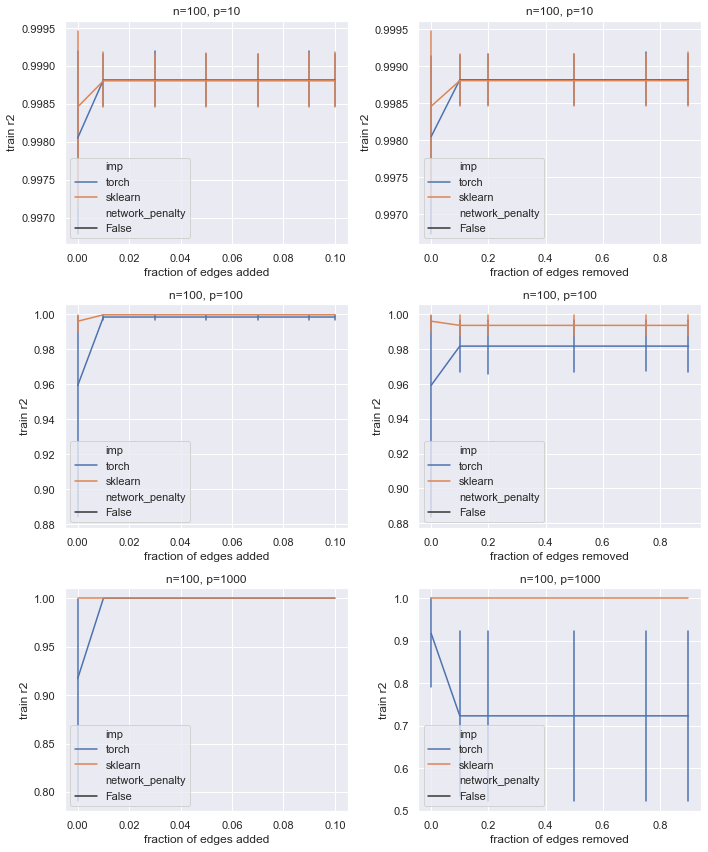

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

num_samples = 100
metric = 'r2'
p_uncorr_frac = 0.1
p_dataset = 'train'
add_fracs = np.unique(results_df['add_frac'].values)
remove_fracs = np.unique(results_df['remove_frac'].values)

sns.set()
fig, axarr = plt.subplots(3, 2)
fig.set_figwidth(10)
fig.set_figheight(12)

for i, num_feats in enumerate((10, 100, 1000)):
    # line plot over add_fracs with remove_frac = 0
    ax1 = axarr[i, 0]
    filter_df = results_df[(results_df['num_samples'] == num_samples) &
                           (results_df['num_features'] == num_feats) &
                           (results_df['dataset'] == p_dataset) &
                           (results_df['uncorr_frac'] == p_uncorr_frac) &
                           (results_df['remove_frac'] == 0.0) &
                           (results_df['metric'] == metric)]
    sns.lineplot(data=filter_df, x='add_frac', y='value',
                 hue='imp', style='network_penalty',
                 err_style='bars', ax=ax1)
    ax1.set_title('n={}, p={}'.format(num_samples, num_feats))
    ax1.set_xlabel('fraction of edges added')
    ax1.set_ylabel('{} {}'.format(p_dataset, metric))
    # line plot over remove_fracs with add_frac = 0
    ax2 = axarr[i, 1]
    filter_df = results_df[(results_df['num_samples'] == num_samples) &
                           (results_df['num_features'] == num_feats) &
                           (results_df['dataset'] == p_dataset) &
                           (results_df['uncorr_frac'] == p_uncorr_frac) &
                           (results_df['add_frac'] == 0.0) &
                           (results_df['metric'] == metric)]
    sns.lineplot(data=filter_df, x='remove_frac', y='value',
                 hue='imp', style='network_penalty',
                 err_style='bars', ax=ax2)
    ax2.set_title('n={}, p={}'.format(num_samples, num_feats))
    ax2.set_xlabel('fraction of edges removed')
    ax2.set_ylabel('{} {}'.format(p_dataset, metric))
    
plt.tight_layout()
    

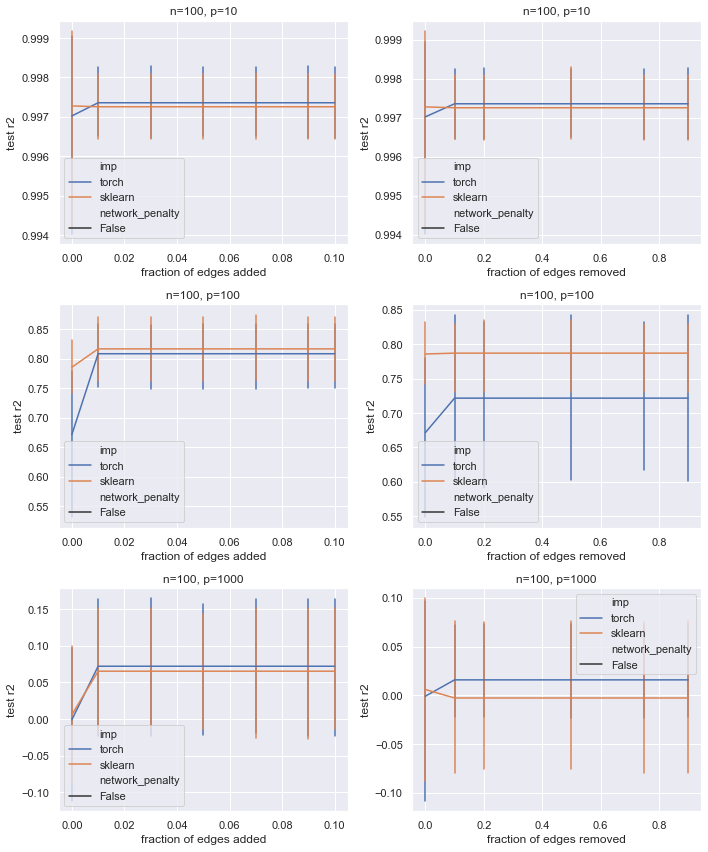

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

num_samples = 100
metric = 'r2'
p_uncorr_frac = 0.1
p_dataset = 'test'
add_fracs = np.unique(results_df['add_frac'].values)
remove_fracs = np.unique(results_df['remove_frac'].values)

sns.set()
fig, axarr = plt.subplots(3, 2)
fig.set_figwidth(10)
fig.set_figheight(12)

for i, num_feats in enumerate((10, 100, 1000)):
    # line plot over add_fracs with remove_frac = 0
    ax1 = axarr[i, 0]
    filter_df = results_df[(results_df['num_samples'] == num_samples) &
                           (results_df['num_features'] == num_feats) &
                           (results_df['dataset'] == p_dataset) &
                           (results_df['uncorr_frac'] == p_uncorr_frac) &
                           (results_df['remove_frac'] == 0.0) &
                           (results_df['metric'] == metric)]
    sns.lineplot(data=filter_df, x='add_frac', y='value',
                 hue='imp', style='network_penalty',
                 err_style='bars', ax=ax1)
    ax1.set_title('n={}, p={}'.format(num_samples, num_feats))
    ax1.set_xlabel('fraction of edges added')
    ax1.set_ylabel('{} {}'.format(p_dataset, metric))
    # line plot over remove_fracs with add_frac = 0
    ax2 = axarr[i, 1]
    filter_df = results_df[(results_df['num_samples'] == num_samples) &
                           (results_df['num_features'] == num_feats) &
                           (results_df['dataset'] == p_dataset) &
                           (results_df['uncorr_frac'] == p_uncorr_frac) &
                           (results_df['add_frac'] == 0.0) &
                           (results_df['metric'] == metric)]
    sns.lineplot(data=filter_df, x='remove_frac', y='value',
                 hue='imp', style='network_penalty',
                 err_style='bars', ax=ax2)
    ax2.set_title('n={}, p={}'.format(num_samples, num_feats))
    ax2.set_xlabel('fraction of edges removed')
    ax2.set_ylabel('{} {}'.format(p_dataset, metric))
    
plt.tight_layout()
    
metrics_df = results_df.copy()

In [5]:
# plot parameter choices for network penalty

result_columns = ['num_samples', 'num_features', 'uncorr_frac',
                  'add_frac', 'remove_frac', 'seed']
results_df = None

def parse_pickle(filename, n, p, uncorr_frac, add_frac,
                 remove_frac, seed, result_columns):
    rc = result_columns[:]
    results = [n, p, uncorr_frac, add_frac, remove_frac, seed]
    with open(filename, 'rb') as f:
        best_params = pkl.load(f)
    for pn, pv in best_params.items():
        rc.append(pn)
        results.append(pv[0])
    return pd.DataFrame([results], columns=rc)

# read results from output directory
for fname in os.listdir(results_dir):
    if os.path.isdir(fname): continue
    if 'best_params' not in fname: continue
    f_sp = os.path.splitext(fname)[0].split('_')
    n = int(f_sp[2].replace('n', ''))
    p = int(f_sp[3].replace('p', ''))
    uncorr_frac = float(f_sp[4].replace('u', ''))
    add_frac = float(f_sp[5].replace('a', ''))
    remove_frac = float(f_sp[6].replace('r', ''))
    seed = int(f_sp[7].replace('s', ''))
    df = parse_pickle(os.path.join(results_dir, fname),
                      n, p, uncorr_frac, add_frac,
                      remove_frac, seed, result_columns)
    if results_df is None:
        results_df = df
    else:
        results_df = pd.concat((results_df, df))

results_df.head(n=10)

,num_samples,num_features,uncorr_frac,add_frac,remove_frac,seed,batch_size,l1_penalty,learning_rate,network_penalty,num_epochs
0,100,100,0.10,0.10,0.20,3,50,0.0,0.010,0.0,500
0,100,100,0.10,0.01,0.00,4,50,0.0,0.005,0.1,500
0,100,100,0.50,0.07,0.00,3,50,0.0,0.010,0.0,500
0,100,100,0.10,0.00,0.10,2,50,0.0,0.005,10.0,500
0,100,10,0.50,0.05,0.75,2,50,0.0,0.010,0.1,200
0,100,10,0.10,0.03,0.10,2,50,0.0,0.010,0.1,200
0,100,10,0.25,0.10,0.10,4,50,0.0,0.005,0.1,500
0,100,100,0.10,0.07,0.50,4,50,0.0,0.005,0.1,200
0,100,10,0.10,0.10,0.20,1,50,0.0,0.005,0.0,500
0,100,100,0.25,0.00,0.50,1,50,0.0,0.010,10.0,500


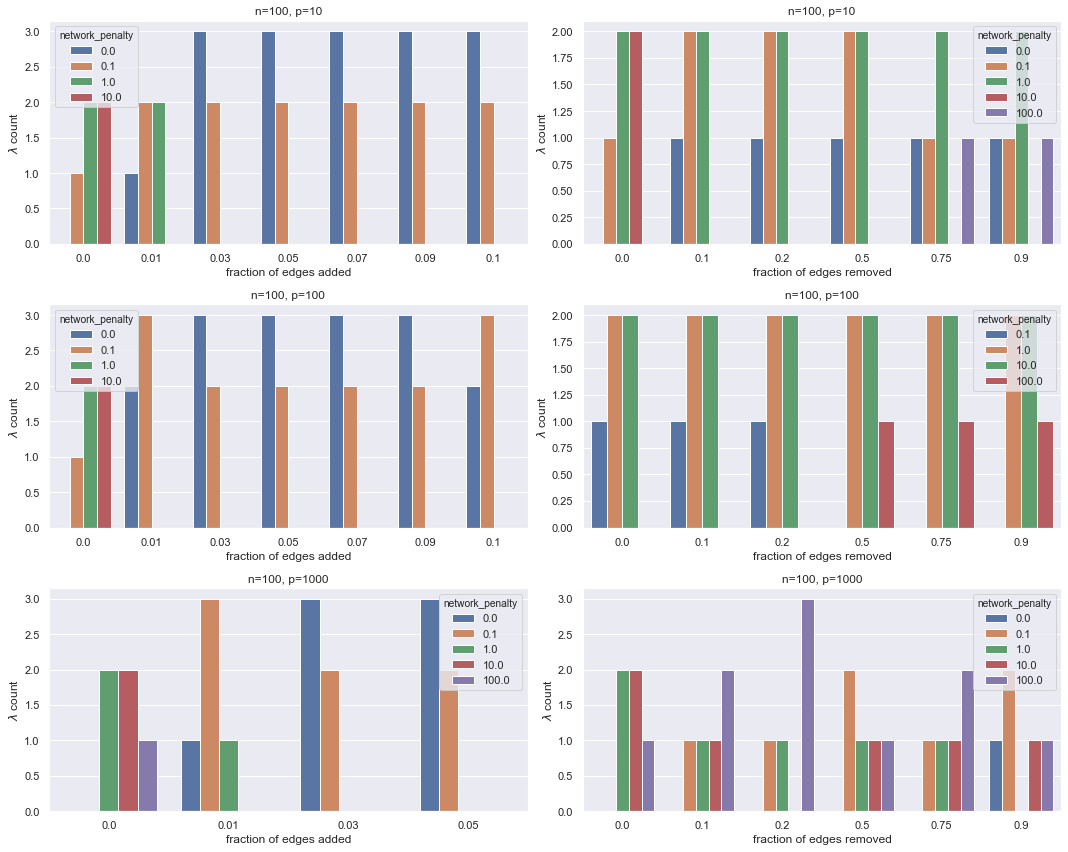

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

num_samples = 100
p_uncorr_frac = 0.1
add_fracs = np.unique(results_df['add_frac'].values)
remove_fracs = np.unique(results_df['remove_frac'].values)

sns.set()
fig, axarr = plt.subplots(3, 2)
fig.set_figwidth(15)
fig.set_figheight(12)

for i, num_feats in enumerate((10, 100, 1000)):
    # line plot over add_fracs with remove_frac = 0
    ax1 = axarr[i, 0]
    filter_df = results_df[(results_df['num_samples'] == num_samples) &
                           (results_df['num_features'] == num_feats) &
                           (results_df['uncorr_frac'] == p_uncorr_frac) &
                           (results_df['remove_frac'] == 0.0)]
    # filter for parameter values
    sns.countplot(data=filter_df, x='add_frac', hue='network_penalty', ax=ax1)
    ax1.set_title('n={}, p={}'.format(num_samples, num_feats))
    ax1.set_xlabel('fraction of edges added')
    ax1.set_ylabel(r'$\lambda$ count')
    # line plot over remove_fracs with add_frac = 0
    ax2 = axarr[i, 1]
    filter_df = results_df[(results_df['num_samples'] == num_samples) &
                           (results_df['num_features'] == num_feats) &
                           (results_df['uncorr_frac'] == p_uncorr_frac) &
                           (results_df['add_frac'] == 0.0)]
    sns.countplot(data=filter_df, x='remove_frac', hue='network_penalty', ax=ax2)
    ax2.set_title('n={}, p={}'.format(num_samples, num_feats))
    ax2.set_xlabel('fraction of edges removed')
    ax2.set_ylabel(r'$\lambda$ count')
    
plt.tight_layout()
    

In [7]:
results_df['imp'] = 'torch'
results_df.set_index(keys=['imp', 'num_samples', 'num_features', 'uncorr_frac', 'add_frac', 'remove_frac', 'seed'], inplace=True)
results_df.sort_index(inplace=True)
print(len(results_df))
results_df.head()

1358


batch_size  \
imp   num_samples num_features uncorr_frac add_frac remove_frac seed               
torch 100         10           0.1         0.0      0.0         0             50   
                                                                1             50   
                                                                2             50   
                                                                3             50   
                                                                4             50   

                                                                      l1_penalty  \
imp   num_samples num_features uncorr_frac add_frac remove_frac seed               
torch 100         10           0.1         0.0      0.0         0            0.0   
                                                                1            0.0   
                                                                2            0.0   
                                                                3            0.0   
                                                                4            0.0   

                                                                      learning_rate  \
imp   num_samples num_features uncorr_frac add_frac remove_frac seed                  
torch 100         10           0.1         0.0      0.0         0             0.010   
                                                                1             0.010   
                                                                2             0.005   
                                                                3             0.010   
                                                                4             0.005   

                                                                      network_penalty  \
imp   num_samples num_features uncorr_frac add_frac remove_frac seed                    
torch 100         10           0.1         0.0      0.0         0                 1.0   
                                                                1                10.0   
                                                                2                10.0   
                                                                3                 1.0   
                                                                4                 0.1   

                                                                      num_epochs  
imp   num_samples num_features uncorr_frac add_frac remove_frac seed              
torch 100         10           0.1         0.0      0.0         0            100  
                                                                1            500  
                                                                2            500  
                                                                3            500  
                                                                4            500

In [8]:
metrics_df_filtered = metrics_df[(metrics_df['dataset'] == 'test') &
                                 (metrics_df['metric'] == metric) &
                                 (metrics_df['network_penalty'] == True)].copy()
metrics_df_filtered.set_index(keys=['imp', 'num_samples', 'num_features', 'uncorr_frac', 'add_frac', 'remove_frac', 'seed'], inplace=True)
metrics_df_filtered.drop(columns=['network_penalty'], inplace=True)
metrics_df_filtered.sort_index(inplace=True)
print(len(metrics_df_filtered))
metrics_df_filtered.head(n=5)

2716


dataset  \
imp     num_samples num_features uncorr_frac add_frac remove_frac seed           
sklearn 100         10           0.1         0.0      0.0         0       test   
                                                                  1       test   
                                                                  2       test   
                                                                  3       test   
                                                                  4       test   

                                                                       metric  \
imp     num_samples num_features uncorr_frac add_frac remove_frac seed          
sklearn 100         10           0.1         0.0      0.0         0        r2   
                                                                  1        r2   
                                                                  2        r2   
                                                                  3        r2   
                                                                  4        r2   

                                                                           value  
imp     num_samples num_features uncorr_frac add_frac remove_frac seed            
sklearn 100         10           0.1         0.0      0.0         0     0.997903  
                                                                  1     0.999001  
                                                                  2     0.991132  
                                                                  3     0.999556  
                                                                  4     0.998794

In [26]:
# left join, replace missing network penalty with 0
join_df = metrics_df_filtered.join(results_df, how='left')
join_df.reset_index(inplace=True)
join_df.fillna(value=0.0, inplace=True)
join_df['imp_penalty'] = join_df.apply(lambda row: '{}_{}'.format(row['imp'], row['network_penalty']), axis=1)
print(len(join_df))
join_df[join_df['imp'] == 'sklearn'].head(n=5)

2716


,imp,num_samples,num_features,uncorr_frac,add_frac,remove_frac,seed,dataset,metric,value,batch_size,l1_penalty,learning_rate,network_penalty,num_epochs,imp_penalty
0,sklearn,100,10,0.1,0.0,0.0,0,test,r2,0.997903,0.0,0.0,0.0,0.0,0.0,sklearn_0.0
1,sklearn,100,10,0.1,0.0,0.0,1,test,r2,0.999001,0.0,0.0,0.0,0.0,0.0,sklearn_0.0
2,sklearn,100,10,0.1,0.0,0.0,2,test,r2,0.991132,0.0,0.0,0.0,0.0,0.0,sklearn_0.0
3,sklearn,100,10,0.1,0.0,0.0,3,test,r2,0.999556,0.0,0.0,0.0,0.0,0.0,sklearn_0.0
4,sklearn,100,10,0.1,0.0,0.0,4,test,r2,0.998794,0.0,0.0,0.0,0.0,0.0,sklearn_0.0


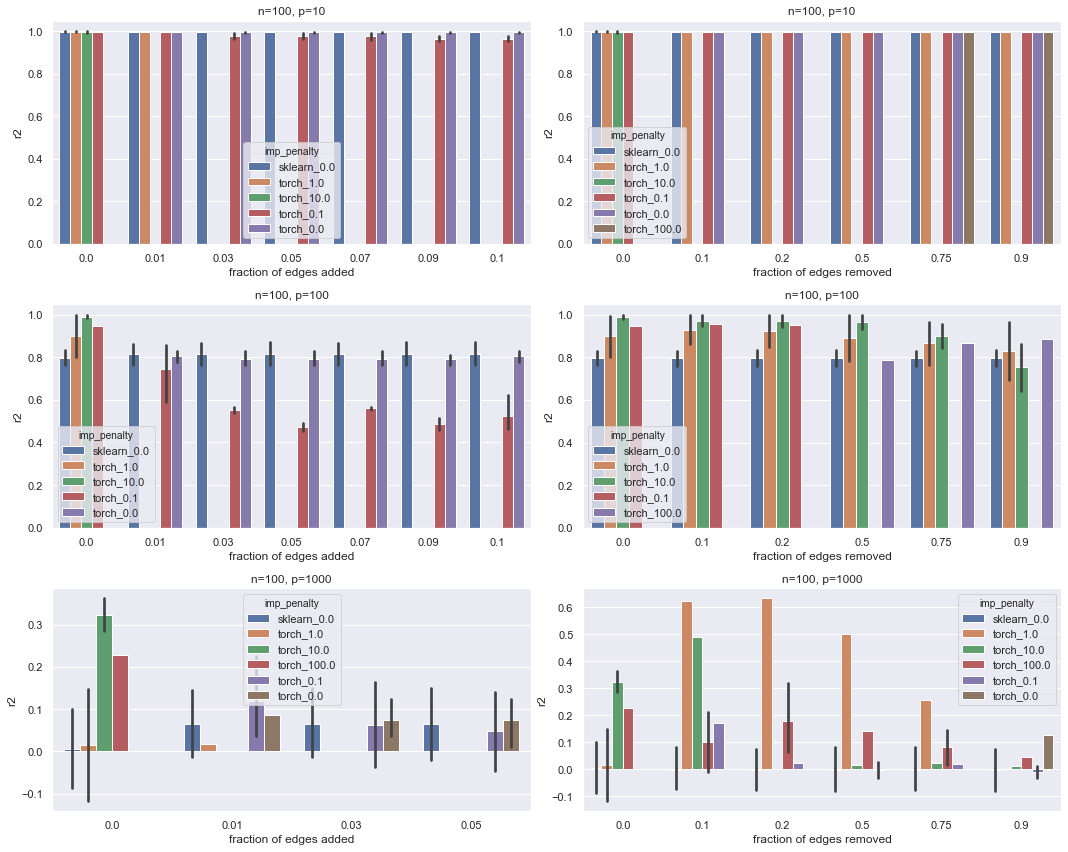

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

num_samples = 100
p_uncorr_frac = 0.1
add_fracs = np.unique(join_df['add_frac'].values)
remove_fracs = np.unique(join_df['remove_frac'].values)

sns.set()
fig, axarr = plt.subplots(3, 2)
fig.set_figwidth(15)
fig.set_figheight(12)

for i, num_feats in enumerate((10, 100, 1000)):
    # line plot over add_fracs with remove_frac = 0
    ax1 = axarr[i, 0]
    filter_df = join_df[(join_df['num_samples'] == num_samples) &
                        (join_df['num_features'] == num_feats) &
                        (join_df['uncorr_frac'] == p_uncorr_frac) &
                        (join_df['remove_frac'] == 0.0)]
    # filter for parameter values
    sns.barplot(data=filter_df, x='add_frac', y='value', hue='imp_penalty', ax=ax1)
    ax1.set_title('n={}, p={}'.format(num_samples, num_feats))
    ax1.set_xlabel('fraction of edges added')
    ax1.set_ylabel(metric)
    # line plot over remove_fracs with add_frac = 0
    ax2 = axarr[i, 1]
    filter_df = join_df[(join_df['num_samples'] == num_samples) &
                        (join_df['num_features'] == num_feats) &
                        (join_df['uncorr_frac'] == p_uncorr_frac) &
                        (join_df['add_frac'] == 0.0)]
    sns.barplot(data=filter_df, x='remove_frac', y='value', hue='imp_penalty', ax=ax2)
    ax2.set_title('n={}, p={}'.format(num_samples, num_feats))
    ax2.set_xlabel('fraction of edges removed')
    ax2.set_ylabel(metric)
    
plt.tight_layout()
    